## Time Series Forecasting 
In this project, we use the Daily Quarterly Sales Growth dataset.

#### Data info:
1.  **date**:"The date that the feature values correspond to. With the exeption of 'sales_growth_yoy' all variables are known as of date. However, date for sales_growth_yoy' are used only to align the predictor and response variables, and have a different known as-of date field. 'sales_growth_yoy' are known as of 'filing_date'"

2. **  company_id**:Company identifier,
3.   **sector_id**:Sector/Industry identifier,
4.   **sales_growth_yoy**:Quarterly Sales Growth YoY (current quarter sales / sales of the same quarter 1 year ago),
5.  **consensus_sales_growth_yoy**:Analyst Estimate of Quarterly Sales Growth YoY,
6.   **filing_date**:The date that the financial statements are filed and when the actual sales for the quarter are publicly known,
7.  **period_end_date**:The date at which the current quarter ends for the company

Note: Observations are indexed by 'date' and 'company_id'.

#### Task:
Model our time series problem, forecasting daily Sales_Growth_YoY for various companies, with ML algorithms. 

Specifically, the problem will be narrow down to "given 'Sales_Growth_YoY' for prior quarters (in terms of days), we forecast the expected 'Sales_Growth_YoY' at the next day for 250 companies in data. 

And the performance have to be better than the consensus estimates.

#### Overall Parts:
- **section 1 👩🏼‍💻 : ** Exploratory Data Analysis
- **section 2 👨🏻‍🔧 : ** Feature Engineering 
- **section 3 👩🏻‍🔬 : ** Model Building & Evaluating

🚀 Ok, so let's start

## 0. Data Preprocessing

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# load raw data 
df = pd.read_csv('forecasting_dataset.csv')

# then convert dtype 'object' to 'datetime'
df['date'] = pd.to_datetime(df['date'])
df['filing_date'] = pd.to_datetime(df['filing_date'])
df['period_end_date'] = pd.to_datetime(df['period_end_date'])

df.head()

,date,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date
0,2014-01-01,1,24,0.035030,0.017983,2014-02-04,2014-01-03
1,2014-01-01,2,21,-0.021529,-0.012229,2014-02-04,2013-12-31
2,2014-01-01,3,7,0.036553,0.040050,2014-02-13,2013-12-31
3,2014-01-01,4,6,0.074647,0.078425,2014-01-15,2013-12-31
4,2014-01-01,5,22,-0.034897,-0.030860,2014-02-24,2013-12-31


## 1.  👩🏼‍💻  Exploratory Data Analysis

#### summary insight:
This dataset summarizes the daily Quarterly Sales Growth of **250 companies** with **27 sectors** over **1826 days** between 2014-01-01 to 2018-12-31. There are total 412,467 observations.

The period of date has the same value of 'sales_growth_yoy' is depended on **'filing_date'** instead of the real period of dates for each quarter. 

Each company has diff period of dates for each quarter. **'filling_date'** provide information to show certain period of days are in same quarter.

The only categorical feature, **'sector_id'**, seems has no directly relation with 'sales_growth_yoy'

Beside id based features, there are many **NAN** in each column. Thus,
   - We don't have all 250 companies info in each day
   - Even 196 number of the companies have over 20 Quarters in the given 5-year period of time. However, some companies only public their Q_sale_growth in the earlier years while some companies public it around recent years. 

In [292]:
# set datetime as index 
df2 = df.set_index('date')

# info
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412467 entries, 2014-01-01 to 2018-12-31
Data columns (total 5 columns):
company_id          412467 non-null int64
sector_id           412467 non-null int64
sales_growth_yoy    397155 non-null float64
filing_date         409671 non-null datetime64[ns]
period_end_date     411038 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 18.9 MB


In [293]:
# count the NaN values of each colunm
df2.isnull().sum()

company_id              0
sector_id               0
sales_growth_yoy    15312
filing_date          2796
period_end_date      1429
dtype: int64

In [294]:
# series of features with number of distinct values
df2.nunique().sort_values() 

sector_id             27
company_id           250
period_end_date      313
filing_date          842
sales_growth_yoy    4553
dtype: int64

In [295]:
# check if we have info about all 250 companies everyday in given 5 years period
# count the number of observations of each feature per timestamp
count = df2.groupby('date')['company_id'].count()
count[count == 250]

Series([], Name: company_id, dtype: int64)

In [297]:
# create df base on quarter (depended on 'filing_date')
Q_df = df2.drop_duplicates()

Q_df[Q_df.company_id == 1].head()

,company_id,sector_id,sales_growth_yoy,filing_date,period_end_date
date,,,,,
2014-01-01,1,24,0.035030,2014-02-04,2014-01-03
2014-02-05,1,24,0.022067,2014-04-29,2014-04-04
2014-04-30,1,24,0.004115,2014-07-29,2014-07-04
2014-07-30,1,24,0.069979,2014-10-28,2014-10-03
2014-10-29,1,24,0.044166,2015-02-03,2015-01-02


In [298]:
# check how many public Qi each company has (178 num of companies have 21 num of quarters, 61 num of companies have less.)
count_Q = Q_df[['company_id','filing_date']]
count_Q = count_Q.groupby(count_Q.company_id).count()
count_Q.filing_date.value_counts()

21    178
22     11
20      7
19      5
14      5
18      4
15      4
10      4
5       3
17      3
16      3
13      3
11      3
4       3
7       3
3       2
12      2
6       2
8       2
9       2
2       1
Name: filing_date, dtype: int64

In [299]:
# check period_end_month's month (showed that companies have various period of date to define their quarters)
Q_df['period_end_year'] = Q_df['period_end_date'].dt.year
Q_df['period_end_month'] = Q_df['period_end_date'].dt.month

Quarter_df = Q_df.reset_index()    
Quarter_df.period_end_month.value_counts() 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


12.0    1171
9.0      975
3.0      952
6.0      946
7.0      138
4.0      134
1.0      122
10.0     120
2.0       61
5.0       58
8.0       57
11.0      52
Name: period_end_month, dtype: int64

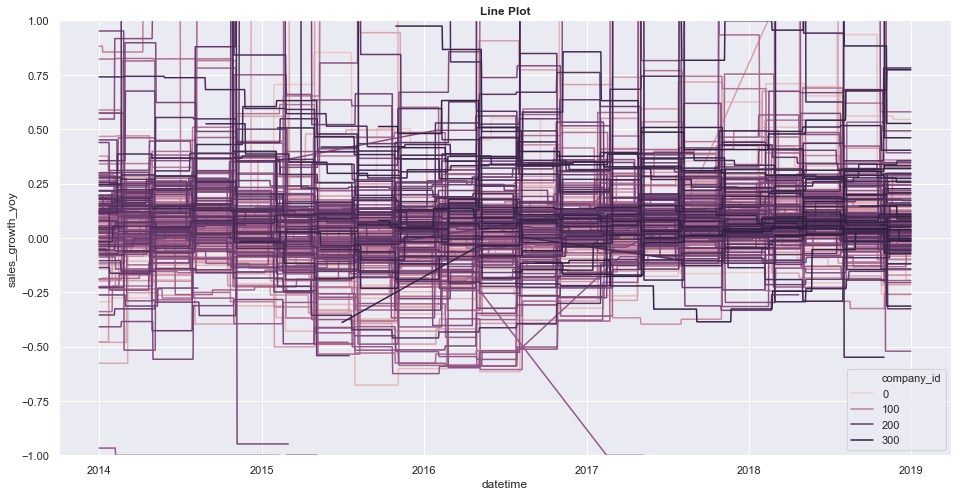

In [490]:
# plot to see the trend of daliy sales_growth_yoy of 250 companies
df_plot = pd.read_csv('forecasting_dataset.csv')
df_plot['datetime'] = pd.to_datetime(df_plot['date'])
sns.set(rc={'figure.figsize':(16,8)})
g = sns.lineplot(x = 'datetime', y = "sales_growth_yoy", hue="company_id", data = df_plot)
g.set(ylim=(-1, 1))
plt.title('Line Plot', weight = 'bold')
plt.show()

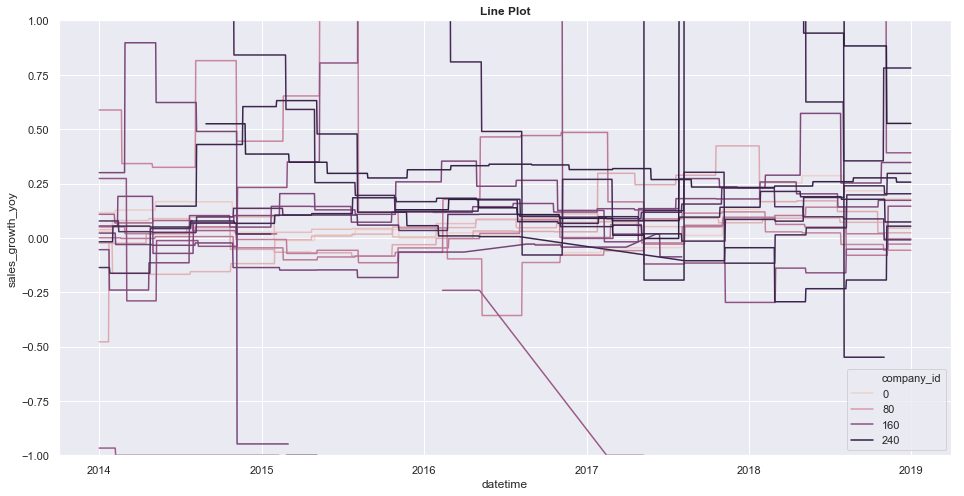

In [558]:
# plot to see sales_growth_yoy of all companies in random picked industry 17
df_plot_1 = df_plot.loc[df_plot.sector_id.isin(['17'])]
sns.set(rc={'figure.figsize':(16,8)})
g = sns.lineplot(x = 'datetime', y = "sales_growth_yoy", hue="company_id", data = df_plot_1)
g.set(ylim=(-1, 1))
plt.title('Line Plot', weight = 'bold')
plt.show()

In [571]:
# check correlation between 'sector_id' and 'sales_growth_yoy'
df.sector_id = df.sector_id.astype('category').cat.codes
df_s = df[['sector_id','sales_growth_yoy']]
df_s.corr()
# 'sector_id' seems like doesn't contribute enough influence to 'sales_growth_yoy' 

,sector_id,sales_growth_yoy
sector_id,1.000000,0.004866
sales_growth_yoy,0.004866,1.000000


# 2. 👨🏻‍🔧 Feature Engineering for Time Series  


## Create lag-based features 
"Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms" stated by Jason Brownlee. [Source: Basic Feature Engineering With Time Series Data in Python](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)

Thus, even our data is across time, it doesn't necessary mean we have to treat it as time series problem. We can take some of information based on time into account through feature generation. 

🚀 Let's transform **time series forecasting problems** into **supervised learning problems** by creating **Lag features**

### 1. Create sales growth at prior 1, 2, and 3 quarter.
Since this is time-series data, there is a lag effect on 'sales_growth_yoy'

i.e Days within **Q(t)** influence days within **Q(t+1)**.

We can predict 'sales_growth_yoy' of days within Q (t+1) given 'sales_growth_yoy' of days within Q (t-1) & Q (t-2) & Q (t-3). Furthermore, we can even create max, SD, and mean of 'sales_growth_yoy' over the last 2 and 3 quarter. 

NOTE: look back till 3 prior quarters becuase a year's information is quite enough to tell the trend of company's sale growth.

Here, we will create lag feature 'Look_back_period' for **'lag_sales_growth_yoy'** to shift by. 

First, we neeed to create feature 'day_diff' and 'days_count_per_Q' to get **'Look_back_period'**.  

In [501]:
# add a column for index as int
df['index'] = df.index 
df['index_all'] = df.index # for later used   

# add new column to check the day gap between filing_date and date.
df['day_diff'] = df['filing_date'] - df['date'] 

# add new column to count how many days in each quarter 
days_count_per_Q = df.groupby(['company_id','filing_date']).size().reset_index(name='days_count_per_Q')

# Merge the dataframes into another dataframe based on 'company_id','filing_date'
df3 = pd.merge(days_count_per_Q, df, how='outer', on=['company_id','filing_date'])
df3 = df3.sort_values(by='date').set_index('index')

# convert day_diff  from timedelta64[ns] to float
df3.day_diff = df3.day_diff / np.timedelta64(1, 'D')

# add new column for later 'lag_sales_growth_yoy' to shift by 
df3['Look_back_period'] = df3['days_count_per_Q'] - df3['day_diff'] 
    
# drop 'period_end_date' since 'sales_growth_yoy' dep on 'filing_date'
df3.drop(['period_end_date'], axis=1, inplace=True)    

# create 'company_index' for 'sales_growth_yoy' to reindex 
grouped = (
    df3.groupby('company_id')
           .apply(lambda x: x.reset_index(drop=True))
           .drop('company_id',axis=1)
           .reset_index()
           .rename(columns={'level_1':'index_company'})
)

# drop NAN of feature 'Look_back_period'
# df = df.replace([np.inf, -np.inf], np.nan).dropna(how="any")
grouped = grouped.dropna(subset=['Look_back_period'])

# convert'Look_back_period' float64 to int64 
grouped['Look_back_period'] = grouped['Look_back_period'].astype(np.int64)

# finally, create 'lag_sales_growth_yoy' 
grouped['lag_sales_growth_yoy'] = (
    grouped['sales_growth_yoy'].reindex(grouped.index_company - grouped['Look_back_period']).values)

# create 'lag2_sales_growth_yoy' 
grouped['lag2_sales_growth_yoy'] = (
    grouped['lag_sales_growth_yoy'].reindex(grouped.index_company - grouped['Look_back_period']).values)

# create 'lag3_sales_growth_yoy' 
grouped['lag3_sales_growth_yoy'] = (
    grouped['lag2_sales_growth_yoy'].reindex(grouped.index_company - grouped['Look_back_period']).values)

#### 🔧Check 'Look_back_period' to see if  all three lag features are defined correctly !  
Take company 1 as example:

In [366]:
grouped_c1 = grouped.loc[grouped.company_id == 1][['date','filing_date','sales_growth_yoy','Look_back_period','lag_sales_growth_yoy','lag2_sales_growth_yoy','lag3_sales_growth_yoy']]
grouped_c1.loc[34:120,:] 

,date,filing_date,sales_growth_yoy,Look_back_period,lag_sales_growth_yoy,lag2_sales_growth_yoy,lag3_sales_growth_yoy
34,2014-02-04,2014-02-04,0.035030,35,NaN,NaN,NaN
35,2014-02-05,2014-04-29,0.022067,1,0.035030,NaN,NaN
36,2014-02-06,2014-04-29,0.022067,2,0.035030,NaN,NaN
37,2014-02-07,2014-04-29,0.022067,3,0.035030,NaN,NaN
38,2014-02-08,2014-04-29,0.022067,4,0.035030,NaN,NaN
39,2014-02-09,2014-04-29,0.022067,5,0.035030,NaN,NaN
40,2014-02-10,2014-04-29,0.022067,6,0.035030,NaN,NaN
41,2014-02-11,2014-04-29,0.022067,7,0.035030,NaN,NaN
42,2014-02-12,2014-04-29,0.022067,8,0.035030,NaN,NaN
43,2014-02-13,2014-04-29,0.022067,9,0.035030,NaN,NaN


** 🥳'lag_sales_growth_yoy' & 'lag2_sales_growth_yoy' & 'lag3_sales_growth_yoy' are defined as desired  ! **

**2013-0X-0X to 2014-02-04 (2013,Q4):** sales_growth_yoy is 0.035030 & lag_sales_growth_yoy is NAN (no date to look back) & lag2_sales_growth_yoy is NAN (no date to look back) & lag3_sales_growth_yoy is NAN (no date to look back) 	 	

👆🏼**2014-02-05 to 2014-04-29 (2014,Q1):** sales_growth_yoy is 0.022067 & lag_sales_growth_yoy is 0.035030 (truly look back) & lag2_sales_growth_yoy is  NAN (no date to look back) & lag3_sales_growth_yoy is NAN (no date to look back) 	 		

👆🏼**2014-04-30 to 2014-07-29 (2014,Q2):** sales_growth_yoy is 0.004115 & lag_sales_growth_yoy is 0.022067  (truly look back) & lag2_sales_growth_yoy is 0.035030   (truly look back) & lag3_sales_growth_yoy is NAN (no date to look back) 	 		

## Window Statistic Features
### 2. Create min, max, average and standard deviation of  'sales_growth_yoy' over the prior 1 & 2 & 3 quarter.

In [502]:
col = grouped.loc[: , 'lag_sales_growth_yoy':'lag3_sales_growth_yoy']
grouped['lag123_mean'] = col.mean(axis=1)
grouped['lag123_max'] = col.max(axis=1)
grouped['lag123_min'] = col.min(axis=1)
grouped['lag123_sd'] = col.std(axis=1)

# check sta
grouped.loc[118:120,:] 

,company_id,index_company,filing_date,days_count_per_Q,date,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,index_all,day_diff,Look_back_period,lag_sales_growth_yoy,lag2_sales_growth_yoy,lag3_sales_growth_yoy,lag123_mean,lag123_max,lag123_min,lag123_sd
118,1,118,2014-04-29,84.0,2014-04-29,24,0.022067,0.031362,27058,0.0,84,0.035030,NaN,NaN,0.035030,0.03503,0.035030,NaN
119,1,119,2014-07-29,91.0,2014-04-30,24,0.004115,0.033401,27288,90.0,1,0.022067,0.03503,NaN,0.028548,0.03503,0.022067,0.009166
120,1,120,2014-07-29,91.0,2014-05-01,24,0.004115,0.033401,27518,89.0,2,0.022067,0.03503,NaN,0.028548,0.03503,0.022067,0.009166


In [503]:
# create dataframe for modeling purpose
model_2_df = (grouped.sort_values('index_all')
            .drop(['index_company','filing_date','days_count_per_Q','day_diff','Look_back_period'], axis=1)
            .set_index('date')
           )

#save model_df as csv 
model_df = model_2_df.to_csv('model.csv')

## 3.  👩🏻‍🔬 Model Building & Model Evaluating 

Given 'Quarterly Sales Growth YoY' for prior 1,2,3 quarters (in terms of days), we forecast the expected 'Quarterly Sales Growth YoY' at the next quarter. Aim at having the performance that are better than the consensus estimates.

In [510]:
import pandas as pd

#read csv
model_df = pd.read_csv('model.csv')

# selecting the right input features that are more likely to identify the relationship with 'sales_growth_yoy'
model_df.corr() 

,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,index_all,lag_sales_growth_yoy,lag2_sales_growth_yoy,lag3_sales_growth_yoy,lag123_mean,lag123_max,lag123_min,lag123_sd
company_id,1.000000,0.094627,0.023313,0.023254,0.046071,-0.008940,-0.005569,-0.008459,-0.008735,0.003274,-0.026187,0.020299
sector_id,0.094627,1.000000,0.004866,0.004840,0.007406,-0.011018,-0.004998,-0.006893,-0.009132,-0.012088,-0.007229,-0.005824
sales_growth_yoy,0.023313,0.004866,1.000000,0.999442,0.002731,0.032543,0.032503,0.032303,0.039763,0.026153,0.050431,-0.013730
consensus_sales_growth_yoy,0.023254,0.004840,0.999442,1.000000,0.002699,0.032527,0.032483,0.032282,0.039741,0.026149,0.050386,-0.013705
index_all,0.046071,0.007406,0.002731,0.002699,1.000000,0.170630,0.188556,0.206795,0.232511,0.176824,0.256832,-0.041857
lag_sales_growth_yoy,-0.008940,-0.011018,0.032543,0.032527,0.170630,1.000000,0.634823,0.189539,0.746087,0.738219,0.550373,0.321659
lag2_sales_growth_yoy,-0.005569,-0.004998,0.032503,0.032483,0.188556,0.634823,1.000000,0.672704,0.943432,0.773940,0.722177,0.263504
lag3_sales_growth_yoy,-0.008459,-0.006893,0.032303,0.032282,0.206795,0.189539,0.672704,1.000000,0.760858,0.657180,0.672815,0.200255
lag123_mean,-0.008735,-0.009132,0.039763,0.039741,0.232511,0.746087,0.943432,0.760858,1.000000,0.884006,0.789145,0.323747
lag123_max,0.003274,-0.012088,0.026153,0.026149,0.176824,0.738219,0.773940,0.657180,0.884006,1.000000,0.456242,0.706600


Even all lag features doesn't have strong relation with 'sales_growth_yoy' we will still take these features as input, since this is time dependent data.

## Avoid Look-ahead bias:


### " Walk-forward cross-validation "
In time series data, we cannot simpliy just split data into 70% train - 30% test or use tranditional k-fold cross validation because each observation is dependent based on time order. Thus, when training model, validating set always  have to be ahead of training set in each run. In other words, prediction of t+n won't be based on future value but past value. This idea is extremely important for time dependent data because look-ahead bias can be avoided. 

- step0: split dataset into k equal blocks of samples. 

each section (train/valid split) i ∈ {1,...,k-p}:  

- stepi: block i to p+(i-1) (train set, optimaization) ; block p+i (validation set, backtest).


Basically, in each section, just move one step forward and append previous validation data point to the training dataset. Repeating it for k-p times until validation data point is reaching block k.

In [511]:
# model_df = model_df.set_index('date')
model_df.head()

,date,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,index_all,lag_sales_growth_yoy,lag2_sales_growth_yoy,lag3_sales_growth_yoy,lag123_mean,lag123_max,lag123_min,lag123_sd
0,2014-01-01,1,24,0.035030,0.017983,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01,2,21,-0.021529,-0.012229,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01,3,7,0.036553,0.040050,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01,4,6,0.074647,0.078425,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01,5,22,-0.034897,-0.030860,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### train each company separately 

In [541]:
# remove NAN
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna(how="any")

# get dataframe of each company
grouped = model_df.groupby('company_id')
[grouped.get_group(x) for x in grouped.groups]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [544]:
from sklearn import linear_model
from sklearn.linear_model import (LinearRegression, Ridge, BayesianRidge, Lasso, ElasticNet)
# from sklearn.feature_selection import RFE, f_regression
# Feature ranking is not performed since we only have 7 input

# walk-forward backtest for each company 
def grouped_backtest(m, Model, n_days):
    #make numpy arrays for each company 
    x = np.array(grouped.get_group(m)[['consensus_sales_growth_yoy','lag_sales_growth_yoy','lag2_sales_growth_yoy',
                       'lag3_sales_growth_yoy','lag123_mean','lag123_max','lag123_sd', 'lag123_min']])

    y = np.array(grouped.get_group(m)['sales_growth_yoy']).reshape(-1,1)

    y_c = np.array(grouped.get_group(m)['consensus_sales_growth_yoy']).reshape(-1,1)
    
    #prediction
    predictions = []
    true_values = []
    for i in reversed(range(1, n_days)):
        x_train = x[:len(x)-i]
        y_train = y[:len(y)-i]
        x_test = x[len(x)-i]
        y_test = y[len(y)-i]
        model = Model()
        model.fit(x_train, y_train)
        predictions.append(model.predict([x_test])[0])
        true_values.append(y_test[0])
    return true_values, predictions


# evaluation metric that accounts for *direction* and *magnitude*: Mean Forecast Error (average of the forecast error values)
def Mean_forecast_error(true_values,predictions,y_c):
    y_c = np.array(model_df['consensus_sales_growth_yoy']).reshape(-1,1)
    forecast_errors_yc = [true_values[i] - y_c[i] for i in range(len(true_values))]
    bias_yc = sum(forecast_errors_yc) * 1.0/len(true_values)
    forecast_errors = [true_values[i] - predictions[i] for i in range(len(true_values))]
    bias = sum(forecast_errors) * 1.0/len(true_values)   
    print('consensus Bias: %f' % bias_yc)
    print('Model Bias: %f' % bias) 

#### Choose Common Supervised Regression Models:
- Linear Regression (baseline)
- Ridge Regression
- BayesianRidge Regression
- Lasso Regression 
- ElasticNet Regression


In [545]:
len(y) # all 1616 days minus 90 days (a quarter), which is around 1530

1616

In [569]:
def all_company_model_performance(n):
    for i in range(1,n):
        print ("Company_" + str(i)+ ", Linear Regression:")
        true_values, predictions = grouped_backtest(i,LinearRegression, 1530)
        Mean_forecast_error(true_values,predictions, y_c)  
        print ("Company_" + str(i)+ ", Ridge Regression:")
        true_values, predictions = grouped_backtest(i,LinearRegression, 1530)
        Mean_forecast_error(true_values,predictions, y_c)  
        print ("Company_" + str(i)+ ", BayesianRidge Regression:")
        true_values, predictions = grouped_backtest(i,LinearRegression, 1530)
        Mean_forecast_error(true_values,predictions, y_c)
        print ("Company_" + str(i)+ ", Lasso Regression:")
        true_values, predictions = grouped_backtest(i,LinearRegression, 1530)
        Mean_forecast_error(true_values,predictions, y_c)
        print ("Company_" + str(i)+ ", ElasticNet Regression:")
        true_values, predictions = grouped_backtest(i,LinearRegression, 1530)
        Mean_forecast_error(true_values,predictions, y_c)        

In [570]:
# take sample of companies to check the performance 
all_company_model_performance(6)

Company_1, Linear Regression:
consensus Bias: -0.124465
Model Bias: 0.016902
Company_1, Ridge Regression:
consensus Bias: -0.124465
Model Bias: 0.016902
Company_1, BayesianRidge Regression:
consensus Bias: -0.124465
Model Bias: 0.016902
Company_1, Lasso Regression:
consensus Bias: -0.124465
Model Bias: 0.016902
Company_1, ElasticNet Regression:
consensus Bias: -0.124465
Model Bias: 0.016902
Company_2, Linear Regression:
consensus Bias: -0.172087
Model Bias: 0.000872
Company_2, Ridge Regression:
consensus Bias: -0.172087
Model Bias: 0.000872
Company_2, BayesianRidge Regression:
consensus Bias: -0.172087
Model Bias: 0.000872
Company_2, Lasso Regression:
consensus Bias: -0.172087
Model Bias: 0.000872
Company_2, ElasticNet Regression:
consensus Bias: -0.172087
Model Bias: 0.000872
Company_3, Linear Regression:
consensus Bias: -0.108048
Model Bias: -0.004198
Company_3, Ridge Regression:
consensus Bias: -0.108048
Model Bias: -0.004198
Company_3, BayesianRidge Regression:
consensus Bias: -0.1

All models have similar performance and has better estimation than consensus'.

Ok, so task is completed! ✅  👩🏻‍✈️   🚨  🧟‍♂️